# HOUSING KAGGLE REGRESSION PROBLEM






### First regression model
OOTB Random Forest Regressor to be used as our ruler.

In [0]:
# loading dataset into the script
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/LeoFernanndes/datasets/master/housing_train.csv')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

In [0]:
# a generic method to arrange the variables
housing = df.copy()

# starting by filling the blank spaces 
for column in housing.columns:
    if housing[column].dtype != 'object':
        housing[column].fillna(housing[column].median(), inplace= True)
    else:
        housing[column] = housing[column].astype('str')
        housing[column].fillna(housing[column].mode(), inplace= True)

In [0]:
## fitting the first regression model 
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score

# splitting the dependent (predictor) and dependent (target) features
x = housing.drop(['SalePrice'], axis= 1)
y = housing['SalePrice']

# applying label encoding
le = LabelEncoder()
for column in x.columns:
    if x[column].dtype == 'object':
        x[column] = le.fit_transform(x[column])

# splitting the data into train and test
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size= 0.2, random_state= 55)

In [0]:
# calling the regressor
reg1 = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

# fitting the model
reg1.fit(x_treino, y_treino)

# making the prediction of target in trein set
prev = reg1.predict(x_teste)


# error evaluation
from sklearn.metrics import mean_squared_log_error
import numpy as np


erro = np.sqrt(mean_squared_log_error(y_teste, prev))

## RMSLE obtained from our first model
erro

0.13061496412307086

In [0]:
# making the predictions over submission set
# loading submission data
url_data = 'https://raw.githubusercontent.com/LeoFernanndes/datasets/master/housing_test.csv'
data = pd.read_csv(url_data)

In [0]:
# filling in the gaps in the same manner as used in the trein set
for column in data.columns:
    if data[column].dtype != 'object':
        data[column].fillna(data[column].mean(), inplace= True)
    else:
        data[column] = data[column].astype('str')
        data[column].fillna(data[column].mode(), inplace= True)

# using label encoder over the test set the same way as used in trein set 
le = LabelEncoder()
for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = le.fit_transform(data[column])

In [0]:
# df for kaggle evaluation
final = reg1.predict(data)
envio = pd.DataFrame({'Id': data['Id'], 'SalePrice': final})

Of corse we didn't expect here anything extremely accurate for some reasons:
* The model itself was implemented just out of the box.
* The approach to fill the missing values using mode to categorical features and mean in the case of numerical ones didn't take in account any exploratory analysis of the variables.
* No methodology for feature engineering and in order to tune model precision by finding cerrelations or opportunities to dimensional reduction.
* All categorical features were encoded with the same method.

## Model improvement attempts


Using feature importances to find the most relevant ones.

In [0]:
featimp = pd.Series(reg1.feature_importances_, index= x_teste.columns).sort_values(ascending=False)
featimp.index
feat_upper = featimp.index[0: 24]

In [0]:
# novo x
x2 = x.copy()
y2 = y.copy()

# novo encoding
le2 = LabelEncoder()
for column in x2.columns:
    if x2[column].dtype == 'object':
        x2[column] = le2.fit_transform(x2[column])

We're now going to use XGBoost Regressor just out of the box like Random Forest above.

But first let's perform an algorithm responsible for selecting the optmal number of features to be used based on that naive feature importances.

In [0]:
from sklearn.svm import SVR
from xgboost import XGBRegressor


y_axis = []
x_axis = []

it = 80

for m in(range(it)):

  error2_ = 0
  n = 10
  
  for i in(range(n)):
    # chamando o modelo
    reg2 = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

    x2_treino, x2_teste, y2_treino, y2_teste = train_test_split(x2, y2, test_size= 0.30, random_state= i**2)

    # ajustando um modelo
    reg2.fit(x2_treino[featimp.index[0: m+1]], y2_treino)

    # fazendo a previsao
    prev2 = reg2.predict(x2_teste[featimp.index[0: m+1]])


    # avaliando o erro
    from sklearn.metrics import mean_squared_log_error
    import numpy as np


    error2 = np.sqrt(mean_squared_log_error(y2_teste, prev2))
    error2_ += error2

  y_axis.append(error2_/n)
  x_axis.append(m)

Let's see how the error vary according to the number os features used in the model.

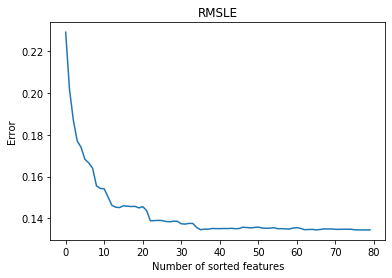

In [0]:
import matplotlib.pyplot as plt


plt.plot(x_axis, y_axis)
plt.title('RMSLE')
plt.xlabel('Number of sorted features')
plt.ylabel('Error')
plt.show()

List of the best 5 numbers of sorted variables.

In [0]:

error_df = pd.DataFrame({'n of features': x_axis,
                         'error': y_axis}).sort_values(by= ['error'], ascending= True)

error_df

,n of features,error
79,79,0.134536
77,77,0.134536
76,76,0.134536
78,78,0.134536
65,65,0.134563
75,75,0.134605
35,35,0.134620
62,62,0.134647
63,63,0.134720
66,66,0.134733


Choosen set of features

In [0]:
# list
limit = list(error_df['n of features'])[0]
featimp.index[0: limit]

Index(['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'BsmtFinSF1', '2ndFlrSF',
       'GarageArea', '1stFlrSF', 'LotArea', 'YearBuilt', 'GarageCars',
       'TotRmsAbvGrd', 'Neighborhood', 'YearRemodAdd', 'FullBath',
       'KitchenQual', 'LotFrontage', 'BsmtQual', 'OpenPorchSF', 'BsmtUnfSF',
       'GarageYrBlt', 'MasVnrArea', 'CentralAir', 'OverallCond', 'Id',
       'GarageType', 'WoodDeckSF', 'GarageFinish', 'ExterQual', 'MoSold',
       'LotShape', 'Fireplaces', 'BsmtFinType1', 'BsmtExposure', 'FireplaceQu',
       'MSZoning', 'BedroomAbvGr', 'SaleCondition', 'YrSold', 'Exterior1st',
       'MSSubClass', 'Exterior2nd', 'BsmtHalfBath', 'LandContour', 'HalfBath',
       'LotConfig', 'MasVnrType', 'BsmtFullBath', 'PoolArea', 'SaleType',
       'HouseStyle', 'RoofStyle', 'LandSlope', 'HeatingQC', 'EnclosedPorch',
       'ExterCond', 'ScreenPorch', 'PoolQC', 'KitchenAbvGr', 'BsmtFinType2',
       'Functional', 'BsmtFinSF2', 'Alley', 'Condition1', 'Foundation',
       'Fence', 'BldgType', 

In [0]:
# loading train data
dataframe = pd.read_csv('https://raw.githubusercontent.com/LeoFernanndes/datasets/master/housing_train.csv')
feat_test = featimp.index[0: limit]

In [0]:
df = dataframe[feat_test]

le2 = LabelEncoder()
for column in df.columns:
    if df[column].dtype == 'object':
      df[column] = df[column].astype('str')
      df[column] = le2.fit_transform(df[column])

x = df
y = dataframe.iloc[:,-1]

In [0]:
# loading submission data
url_data = 'https://raw.githubusercontent.com/LeoFernanndes/datasets/master/housing_test.csv'
data1 = pd.read_csv(url_data)

In [0]:
data = data1[feat_test]

In [0]:
# filling in the gaps
for column in data.columns:
    if data[column].dtype != 'object':
        data[column].fillna(data[column].median(), inplace= True)
    else:
        data[column] = data[column].astype('str')
        data[column].fillna(data[column].mode(), inplace= True)

# label encoding test data the same way as train
for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = le2.fit_transform(data[column])

In [0]:
# calling the regressor

reg = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)


# fittin the model
reg.fit(x, y)


# making the prediction
prev = reg.predict(data)

# creating submission dataset
envio = pd.DataFrame({'Id': data1['Id'], 'SalePrice': prev})

In [0]:
# saving the df in a csv to be uploaded

#path = r'C:\Users\Avell\Desktop\Python\github\datasets'
#nome = '\housing_submission_2.csv'
#envio.to_csv(path+nome, index= False)

##References

Complete Guide to Parameter Tuning in XGBoost with codes in Python

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

Complete Machine Learning Guide to Parameter Tuning in Gradient Boosting (GBM) in Python

https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

Understanding the Bias-Variance Tradeoff

https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229

Fundamental Techniques of Feature Engineering for Machine Learning

https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114